In [23]:
import wandb
api = wandb.Api()

import numpy as np
import pandas as pd

import tqdm
from functools import reduce
from itertools import product
from collections import defaultdict
from tqdm.contrib.itertools import product as tqdm_product

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [24]:
result_date = ["20231110", "20231105", "20231109", "20231117"]

count_data  = defaultdict(int)
for run in api.runs("ntuyianchen/g_main"):
    check_date  = reduce(lambda x, y: x or y in run.name, [False]+result_date)
    if run.state == "finished" and check_date and run.summary["epoch"] == 30:
        if "QuantumRotQCGNN" in run.name and "gl1" not in run.name:
            continue
        model = run.name.split()[0] + " | " + run.config["abbrev"]
        count_data[model] += 1

count_data

defaultdict(int,
            {'QuantumRotQCGNN_qidx3_qnn6_gl1_gr9 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr6 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr3 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr6 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr6 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr9 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr9 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr3 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn3_gl1_gr9 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn3_gl1_gr9 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn3_gl1_gr6 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr9 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn3_gl1_gr3 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn3_gl1_gr6 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr6 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qn

In [25]:
data_frame = pd.DataFrame()
for run in tqdm.tqdm(api.runs(f"ntuyianchen/g_main")):
    check_date  = reduce(lambda x, y: x or y in run.name, [False]+result_date)
    if run.state == "finished" and check_date and run.summary["epoch"] == 30:
        # since valid has different steps, should be export independently ...
        hist_train = run.history(keys=["epoch", "epoch_time", "train_acc_epoch", "train_loss_epoch", "train_roc_auc"], x_axis="epoch")
        hist_valid = run.history(keys=["valid_acc_epoch", "val_roc_auc"], x_axis="epoch")
        temp_frame = pd.concat([hist_train,  hist_valid[["valid_acc_epoch", "val_roc_auc"]]], axis=1)

        # add config column
        config_keys = ["model_name", "abbrev", "rnd_seed"]
        if "Classical2PCGNN" in run.name:
            config_keys += ["gnn_hidden", "gnn_out"]
            temp_frame["legend"] = f"MPGNN(D={run.config['gnn_out']})"
        elif "QuantumRotQCGNN" in run.name:
            if "gl1" not in run.name:
                continue
            config_keys += ["gnn_nn_qubits", "gnn_reupload", "gnn_layers"]
            temp_frame["legend"] = f"QCGNN(D={run.config['gnn_nn_qubits']},R={run.config['gnn_reupload']})"
        for key in config_keys:
            temp_frame[key] = run.config[key]
        
        # concat
        data_frame = temp_frame if data_frame is None else pd.concat([data_frame, temp_frame], axis=0)

100%|██████████| 92/92 [00:42<00:00,  2.15it/s]


In [26]:
# Classical : gnn_hidden = gnn_out = [3,6,9] -> 3 * 3(rnd_seed) * 2(channel) = 18
# Quantum   : gnn_nn_qubits = [3,6,9] | gnn_reupload = [3,6,9] | -> 3 * 3 * 3(rnd_seed) * 2(channel) = 54
assert len(data_frame) / 30 == (18+54)
data_frame.iloc[[15*i for i in range(2*len(data_frame)//30)]]

,epoch,epoch_time,train_acc_epoch,train_loss_epoch,train_roc_auc,valid_acc_epoch,val_roc_auc,legend,model_name,abbrev,rnd_seed,gnn_nn_qubits,gnn_reupload,gnn_layers,gnn_hidden,gnn_out
0,0,13103.594727,0.751375,0.534609,0.824673,0.7790,0.857621,"QCGNN(D=6,R=9)",QuantumRotQCGNN,TT-QCD,0,6.0,9.0,1.0,NaN,NaN
15,15,13174.524414,0.806500,0.428406,0.883269,0.8085,0.883299,"QCGNN(D=6,R=9)",QuantumRotQCGNN,TT-QCD,0,6.0,9.0,1.0,NaN,NaN
0,0,13161.696289,0.663625,0.681581,0.708949,0.7540,0.822828,"QCGNN(D=6,R=9)",QuantumRotQCGNN,TT-QCD,2,6.0,9.0,1.0,NaN,NaN
15,15,13248.916992,0.803000,0.438248,0.877415,0.8090,0.890839,"QCGNN(D=6,R=9)",QuantumRotQCGNN,TT-QCD,2,6.0,9.0,1.0,NaN,NaN
0,0,12995.787109,0.690500,0.640270,0.729687,0.7545,0.840891,"QCGNN(D=6,R=9)",QuantumRotQCGNN,TT-QCD,1,6.0,9.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,8819.545898,0.727750,0.549726,0.798243,0.7330,0.810758,"QCGNN(D=3,R=9)",QuantumRotQCGNN,BB-QCD,0,3.0,9.0,1.0,NaN,NaN
0,0,6280.850586,0.629375,1.091473,0.645483,0.6675,0.747899,"QCGNN(D=3,R=6)",QuantumRotQCGNN,BB-QCD,0,3.0,6.0,1.0,NaN,NaN
15,15,6238.475098,0.720875,0.558284,0.788695,0.7150,0.796156,"QCGNN(D=3,R=6)",QuantumRotQCGNN,BB-QCD,0,3.0,6.0,1.0,NaN,NaN
0,0,3600.556152,0.617750,0.850964,0.629622,0.6605,0.734157,"QCGNN(D=3,R=3)",QuantumRotQCGNN,BB-QCD,0,3.0,3.0,1.0,NaN,NaN


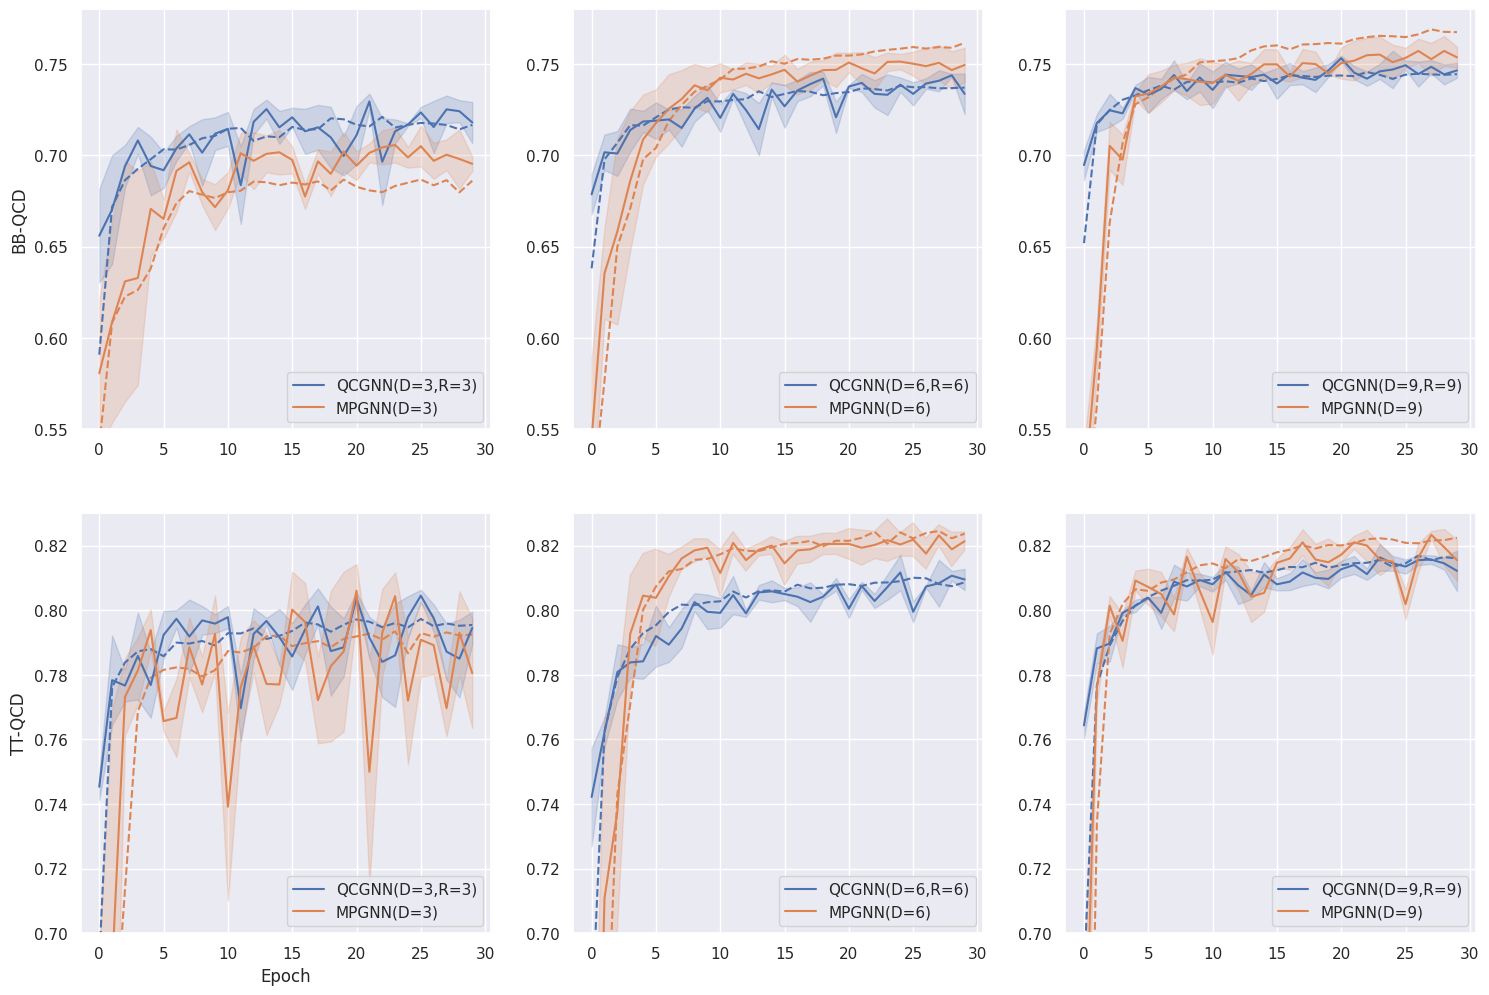

In [27]:
# `sns.errorbar`: https://seaborn.pydata.org/tutorial/error_bars.html

abbrev_list   = ["BB-QCD", "TT-QCD"]
out_dim_list  = [3,6,9]
num_r, num_c  = len(abbrev_list), len(out_dim_list)
fig, ax       = plt.subplots(num_r, num_c, figsize=(6*num_c,6*num_r))
color_palette = sns.color_palette(n_colors=2)

for row, col in product(range(num_r), range(num_c)):
    abbrev  = abbrev_list[row]
    out_dim = out_dim_list[col]
    idx     = (data_frame["abbrev"]==abbrev) & ((data_frame["gnn_out"]==out_dim) | ((data_frame["gnn_nn_qubits"]==out_dim) & (data_frame["gnn_reupload"]==out_dim)))
    sns.lineplot(data_frame[idx], x="epoch", y="train_acc_epoch", hue="legend", ax=ax[row][col], palette=color_palette, err_style=None, legend=False, linestyle='--')
    sns.lineplot(data_frame[idx], x="epoch", y="valid_acc_epoch", hue="legend", ax=ax[row][col], palette=color_palette, errorbar=("se", 1))

    if (row,col) == (0,0):
        ax[row][col].set_xlabel("")
        ax[row][col].set_ylabel("BB-QCD")
    elif (row,col) == (1,0):
        ax[row][col].set_xlabel("Epoch")
        ax[row][col].set_ylabel("TT-QCD")
    else:
        ax[row][col].set_xlabel("")
        ax[row][col].set_ylabel("")

    if abbrev == "BB-QCD":
        ax[row][col].set_ylim(0.55, 0.78)
    elif abbrev == "TT-QCD":
        ax[row][col].set_ylim(0.70, 0.83)

    sns.move_legend(ax[row][col], "lower right", title=None)

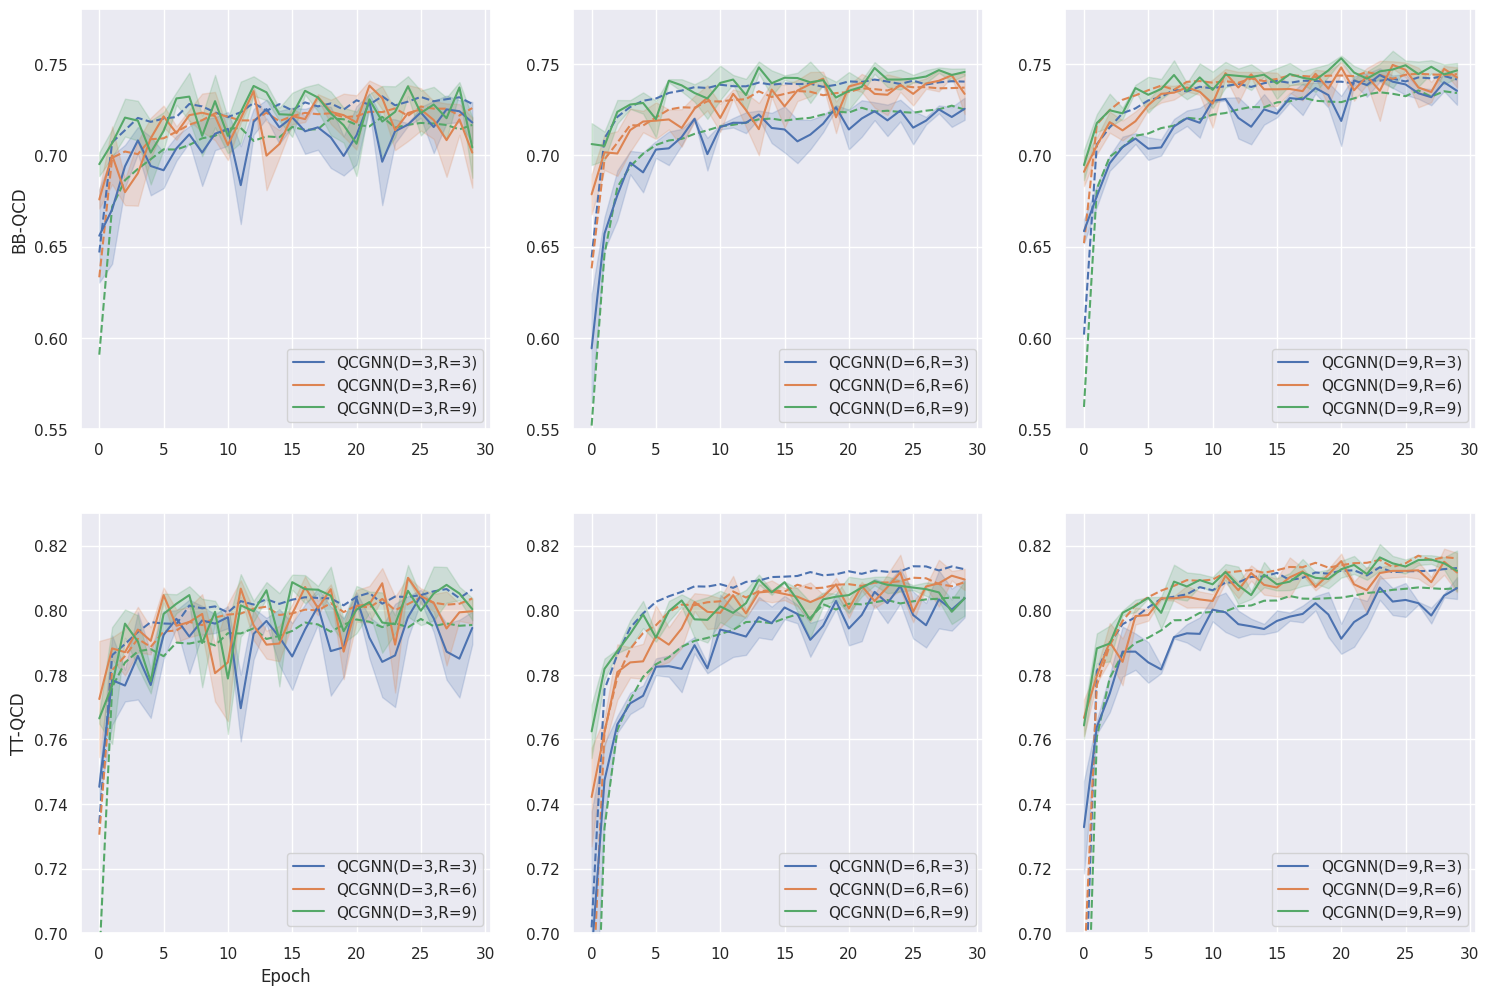

In [37]:
# `sns.errorbar`: https://seaborn.pydata.org/tutorial/error_bars.html

abbrev_list   = ["BB-QCD", "TT-QCD"]
out_dim_list  = [3,6,9]
num_r, num_c  = len(abbrev_list), len(out_dim_list)
fig, ax       = plt.subplots(num_r, num_c, figsize=(6*num_c,6*num_r))
color_palette = sns.color_palette(n_colors=3)

for row, col in product(range(num_r), range(num_c)):
    abbrev    = abbrev_list[row]
    out_dim   = out_dim_list[col]
    idx       = (data_frame["abbrev"]==abbrev) & (data_frame["gnn_nn_qubits"]==out_dim)
    hue_order = [f"QCGNN(D={3*col+3},R={3*i+3})" for i in range(3)]
    sns.lineplot(data_frame[idx], x="epoch", y="train_acc_epoch", hue="legend", ax=ax[row][col], palette=color_palette, err_style=None, legend=False, linestyle='--')
    sns.lineplot(data_frame[idx], x="epoch", y="valid_acc_epoch", hue="legend", ax=ax[row][col], palette=color_palette, errorbar=("se", 1), hue_order=hue_order)
    
    if (row,col) == (0,0):
        ax[row][col].set_xlabel("")
        ax[row][col].set_ylabel("BB-QCD")
    elif (row,col) == (1,0):
        ax[row][col].set_xlabel("Epoch")
        ax[row][col].set_ylabel("TT-QCD")
    else:
        ax[row][col].set_xlabel("")
        ax[row][col].set_ylabel("")

    if abbrev == "BB-QCD":
        ax[row][col].set_ylim(0.55, 0.78)
    elif abbrev == "TT-QCD":
        ax[row][col].set_ylim(0.70, 0.83)

    sns.move_legend(ax[row][col], "lower right", title=None)